# Introduction

The Herschel/SPIRE Spectral Feature Finder (FF) is an automated tool which detects significant spectral features within SPIRE Fourier Transform Spectrometer (FTS) data. The FF is designed to facilitate data-mining and preliminary analysis of SPIRE spectral data and is not a replacement for detailed scientific analysis. A full introduction to the FF routine and products is presented in the project's [readme](http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/spectral_feature_catalogue/SpectralFeatureFinder_releaseNote.html) page. The FF products can be accessed from this [archive](https://www.cosmos.esa.int/web/herschel/spire-spectral-feature-catalogue). In this notebook we show the structure of the FF products and provide examples of how to search FF products using typical search criteria. We also include examples for visually inspecting FF products and SPIRE data. A brief section on estimating integrated line flux for features detected by the FF is also presented. 

The full set of FF products can be downloaded from the link above, however, in this notebook we will only download select products when necessary. Products will be downloaded from the archive and will be placed in a chosen directory which we will assigned to the variable `data_dir`. The archive has a directory structure identical to the FF products you can download from the link above.

The standard Anaconda distribution is recommended as it includes most of the packages required to run this notebook by default. However, Anaconda does not include the `lmfit` package and likely needs to be installed by the user. This notebook makes use of a custom package called `spireff` developed to aid in the acquisition, manipulation, and visualization of FF and SPIRE Herschel Science Archive (HSA) products. `spireff` is available in the `archive` and has the dependencies listed below.

## Acknowledging or Citing the Feature Finder Software or Products If you plan to use this notebook
for research or work publications we ask that you please cite the following Feature Finder Paper:

* R Hopwood, I Valtchanov, L D Spencer, J Scott, C Benson, N Marchili, N Hładczuk, E T Polehampton, N Lu, G Makiwa, D A Naylor, B G Gom, G Noble, M J Griffin, The Herschel SPIRE Fourier Transform Spectrometer Spectral Feature Finder I. The Spectral Feature Finder and Catalogue, Monthly Notices of the Royal Astronomical Society, Volume 496, Issue 4, August 2020, Pages 4874–4893, https://doi.org/10.1093/mnras/staa1612

* and provide link and refer to DOI [10.5270/esa-lysf2yi](https://doi.org/10.5270/esa-lysf2yi)

This notebook was developed with Python 3.7 and the following packages:
* Numpy 1.18.1
* Matplotlib 3.1.3
* Astropy 4.0.1
* Scipy 1.4.1
* Pandas 1.0.4
* lmfit 0.9.13
* Requests 2.23.0
* Other standard packages

In [3]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from scipy.interpolate import interp1d
%matplotlib inline

spireff_path = './spireff'
sys.path.insert(1, spireff_path)
import spireff.io as spio
import spireff.figtools as tools
#from spireff.gui import GUI

import warnings
warnings.filterwarnings('ignore')

#All saved data will be stored in this directory
home = os.path.expanduser('~')
save_dir = os.path.join(home,'savedata')
if (not os.path.isdir(save_dir)):
    os.mkdir(save_dir)

# SPIRE Automated Feature Extraction Catalogue

The Automated Feature Extraction Catalogue (SAFECAT) collates all of the features detected by the FF and their associated parameters. It can be used as a convenient resource for searching FF products. A version of SAFECAT which shifts detected features to their rest frame based on the radial velocity estimate obtained by the FF also exists. SAFECAT can be accessed with the following function.

In [4]:
SAFECAT = spio.safecat(save_dir=save_dir, save=True)
SAFECAT = Table.read(SAFECAT)
SAFECAT.info()

<Table length=332880>
       name        dtype   unit     class     n_bad 
----------------- ------- ------ ------------ ------
            obsid   int32              Column      0
            opDay   int32              Column      0
        frequency float64    GHz       Column      0
   frequencyError float64    GHz MaskedColumn     13
              SNR float64    GHz       Column      0
         detector    str5              Column      0
              row   int32              Column      0
           column   int32              Column      0
               ra float64    deg       Column      0
              dec float64    deg       Column      0
      featureFlag float64              Column      0
         velocity float64 km / s MaskedColumn  39799
    velocityError float64 km / s MaskedColumn  39818
     velocityFlag   str10              Column      0
      calibration   str15              Column      0
         sampling   str15              Column      0
              bgs   int3

FF products are natively stored as FITS files. This file format is quite useful for storing general data and is easy to work with, but not ideal for visual inspection. To improve visualization, we convert SAFECAT to an Astropy table.

## Searching the Catalogue

In this section we demonstrate how to search SAFECAT using a select few search criteria. The searches shown generalize naturally to other SAFECAT columns show above.

### Single Column

To search for all rows with a specific observation identification number (obsid) one can use the code below. Note this works for any valid column name, not just "obsid".

In [5]:
column, val = 'obsid', 1342188190
ind = np.where(SAFECAT[column] == val)[0]

newSAFECAT = SAFECAT.copy() #Creates a copy of the SAFECAT table that has reduced significant figures

colTitles = ['frequency', 'frequencyError', 'SNR', 'ra', 'dec', 'velocity', 'velocityError', 'velocityCorrFreq', 'templateFrequency']

for i in range(len(colTitles)):
    if colTitles[i] == 'ra' or colTitles[i] == 'dec':
        newSAFECAT[colTitles[i]].info.format = "0.5f"
    else:
        newSAFECAT[colTitles[i]].info.format = "0.2f"

print(newSAFECAT[ind])#.show_in_notebook() *replace print() with .show_in_notebook() for high quality tables

  obsid    opDay frequency ... species      transition     comment
                    GHz    ...                                    
---------- ----- --------- ... ------- ------------------- -------
1342188190   217    461.01 ... CO, v=0             (4 _ 3)       _
1342188190   217    550.60 ...  C-13-O             (5 _ 4)       _
1342188190   217    576.31 ... CO, v=0             (5 _ 4)       _
1342188190   217    661.10 ...  C-13-O             (6 _ 5)       _
1342188190   217    691.46 ... CO, v=0             (6 _ 5)       _
1342188190   217    771.18 ...  C-13-O             (7 _ 6)      a_
1342188190   217    771.18 ...  o-H2CO (11 1 11 _ 10 1 10)       b
1342188190   217    806.66 ... CO, v=0             (7 _ 6)       _
1342188190   217    809.23 ...  C-atom          (3P2->3P1)       _
1342188190   217    921.78 ... CO, v=0             (8 _ 7)       _
       ...   ...       ... ...     ...                 ...     ...
1342188190   217   1461.16 ...      --                  --    

### Multiple Columns

The above observation targets an extended source. In the FF extended and semi-extended sources are processed using both their point-source and extended-source calibrated spectra. If only the extended calibration products are desired, one can use the following code. Note this extends naturally to any number of columns and values.

In [6]:
column1, val1 = 'obsid', 1342188190
column2, val2 = 'calibration', 'extendedSource'
ind = np.where((SAFECAT[column1] == val1) & \
               (SAFECAT[column2] == val2))[0]

print(newSAFECAT[ind])#.show_in_notebook()

  obsid    opDay frequency frequencyError ... species transition comment
                    GHz         GHz       ...                           
---------- ----- --------- -------------- ... ------- ---------- -------
1342188190   217    461.02           0.02 ... CO, v=0    (4 _ 3)       _
1342188190   217    550.64           0.05 ...  C-13-O    (5 _ 4)       _
1342188190   217    576.30           0.01 ... CO, v=0    (5 _ 4)       _
1342188190   217    661.05           0.06 ...  C-13-O    (6 _ 5)       _
1342188190   217    691.47           0.01 ... CO, v=0    (6 _ 5)       _
1342188190   217    771.23           0.06 ...  C-13-O    (7 _ 6)       _
1342188190   217    806.65           0.02 ... CO, v=0    (7 _ 6)       _
1342188190   217    809.30           0.02 ...  C-atom (3P2->3P1)       _
1342188190   217    811.75           0.15 ...      --         --    noID
1342188190   217    851.97           0.12 ...      --         --    noID
       ...   ...       ...            ... ...     .

### Range of Values

If the user is interested in only a range of values, a range of frequency values for example, one can use the following code. Again, this extends to any number of columns and values.

In [7]:
column1, val1 = 'obsid', 1342188190
column2, val2 = 'calibration', 'extendedSource'
column3, v_range = 'frequency', (500.0, 700.0)
ind = np.where((SAFECAT[column1] == val1) & \
               (SAFECAT[column2] == val2) & \
               (SAFECAT[column3] >= v_range[0]) & \
               (SAFECAT[column3] <= v_range[1]))[0]

print(newSAFECAT[ind])#.show_in_notebook()

  obsid    opDay frequency frequencyError ... species transition comment
                    GHz         GHz       ...                           
---------- ----- --------- -------------- ... ------- ---------- -------
1342188190   217    550.64           0.05 ...  C-13-O    (5 _ 4)       _
1342188190   217    576.30           0.01 ... CO, v=0    (5 _ 4)       _
1342188190   217    661.05           0.06 ...  C-13-O    (6 _ 5)       _
1342188190   217    691.47           0.01 ... CO, v=0    (6 _ 5)       _
1342188190   217    576.27           0.05 ...      --         --    noID
1342188190   217    691.47           0.05 ...      --         --    noID
1342188190   217    576.33           0.04 ...      --         --    noID
1342188190   217    691.39           0.05 ...      --         --    noID
1342188190   217    576.30           0.02 ...      --         --    noID
1342188190   217    691.49           0.03 ...      --         --    noID
       ...   ...       ...            ... ...     .

### Coordinate Neighborhood

When searching sky coordinates values, the use of the `astropy.coordinates` module is recommended. This module, along with the `astropy.wcs` module, provide convenient high-level functionality for working with sky coordinates and astronomy data.

As a demonstration, we will search SAFECAT for columns within 1 arcmin of ra = 316.75 deg, dec = 42.23 deg.

In [8]:
ra, dec = [316.75], [42.23]
radius = 1*u.arcmin
coord = SkyCoord(ra, dec, unit='deg')
search_coords = SkyCoord(SAFECAT['ra'], SAFECAT['dec'], unit='deg')
ind, _, sep, _ = coord.search_around_sky(search_coords, radius)

print('Maximum separation :', max(sep))

print(newSAFECAT[ind])#.show_in_notebook()

Maximum separation : 0d00m59.97131877s
  obsid    opDay frequency frequencyError ...  species  transition comment
                    GHz         GHz       ...                             
---------- ----- --------- -------------- ... --------- ---------- -------
1342188197   217    460.99           0.01 ...   CO, v=0    (4 _ 3)       _
1342188197   217    550.94           0.09 ...    C-13-O    (5 _ 4)       _
1342188197   217    566.87           0.09 ...        --         --    noID
1342188197   217    576.27           0.01 ...   CO, v=0    (5 _ 4)       _
1342188197   217    624.07           0.11 ... HCO+, v=0    (7 _ 6)       _
1342188197   217    661.15           0.11 ...    C-13-O    (6 _ 5)       _
1342188197   217    680.20           0.13 ...        --         --    noID
1342188197   217    691.41           0.01 ...   CO, v=0    (6 _ 5)       _
1342188197   217    713.32           0.19 ... HCO+, v=0    (8 _ 7)       _
1342188197   217    771.10           0.07 ...    C-13-O    (7

## Graphical Interface

A custom graphical interface has been designed to provide a quick interactive way to search FF products and find relevant information. The interface uses `SAFECAT` to facilitate its functionality and runs on `tkinter`. The graphical interface can be used by executing the following cell.

In [9]:
#GUI(SAFECAT, save_dir=save_dir)

# Observation Specific Products

A set of observation specific products are generated for each observation processed by the FF. These products consist of a fits table for the set of detected features and associated parameters found within the spectrum, a fits table for the fitted continuum parameters, and a quick inspection postcard. The `spireff` module provides a convenience function for retrieving these products from the archive.

## Sparse Products

In this section we focus on sparse products.

In [10]:
spio.set_verbose(True)
sparse_obsid = 1342270193
result = spio.get_observation(sparse_obsid, useFF=True, useHsa=True, 
                              save_dir=save_dir, save=True)


--- 1342270193 ---
spec_type = calHpdp
obs_mod = sparse
cal = point

Retrieving FF Files.

Retrieving HSA Files.

Downloading... be patient

___ Summary ___
ff:
--sparse_point
----postcard
----catalogue
----continuum
spectrum:
_____ End _____



The `get_observation` function can print useful information about the products it retrieves. These print statements can be enabled or disabled (the default) using the `set_verbose` function. The print statements above show the `spec_type`, `obs_mode`, and `cal` used when retrieving products, which can be set manually in the `get_observation` function. However, if `useFF=True` and `spec_type=None` (the default) these values are overwritten by their nominal values as determined by the FF. If `useHsa=True`, the function will also return level 2 HSA (spectrometer or photometer) products. If `spec_type` is 'calHpdp' or 'calBgs', the corresponding [HPDP](http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/cal_targets) or [BGS](http://archives.esac.esa.int/hsa/legacy/HPDP/SPIRE/SPIRE-S/BKGS/) spectra will be returned. To get the standard HSA products for these obsids, set `spec_type='spg'`.  

The `result` of `get_observation` is a dictionary of dictionaries containing the FF products for the input obsid. The key structure of `result` can get complicated but calling `spio._keys_summary(result)` will print a summary of the key structure of `result`. This is done automatically in the `get_observation` function and the output is shown above.

Let's inspect the content of the FF products in the `result` variable. As previously mentioned, FF products are natively stored as fits files. The 'catalogue' field contains an HDUList and its `data` table contains the features catalogue.

In [11]:
sp_prod = result['ff']['sparse_point']

sp_prod_cat = sp_prod['catalogue']
print('Type :', type(sp_prod_cat), '\n')
sp_prod_cat.info(); print()

sp_cat_table = Table.read(sp_prod_cat, hdu='data')
#Reduce the columns to 2 significant figures
sp_cat_table['frequency'].info.format = "0.2f"
sp_cat_table['frequencyError'].info.format = "0.4f"
sp_cat_table['SNR'].info.format = "0.2f"

print(sp_cat_table)#.show_in_notebook()

Type : <class 'astropy.io.fits.hdu.hdulist.HDUList'> 

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  data          1 BinTableHDU    142   24R x 6C   [1D, 1D, 1D, 5A, 1D, 1J]   

frequency frequencyError  SNR   detector featureFlag nccFlag
   GHz         GHz                                          
--------- -------------- ------ -------- ----------- -------
   460.96         0.0099  41.91    SLWC3         0.1       0
   576.27         0.0115  74.73    SLWC3         0.1       0
   661.10         0.1004   9.80    SLWC3         0.0       0
   691.39         0.0139 146.53    SLWC3         0.0       0
   771.08         0.0633   8.20    SLWC3         0.0       0
   806.59         0.0100 189.41    SLWC3         0.0       0
   809.15         0.0359  15.02    SLWC3         0.0       0
   835.06         0.0370  78.09    SLWC3         0.0       0
   881.18         0.0600   9.68    SLWC3       

The interesting meta data is found in the catalogue table header.

In [12]:
sp_prod_cat['data'].header

XTENSION= 'BINTABLE'           / marks beginning of new HDU                     
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    2 / number of axes                                 
NAXIS1  =                   41 / size of the n'th axis                          
NAXIS2  =                   24 / size of the n'th axis                          
PCOUNT  =                    0 / Required value                                 
GCOUNT  =                    1 / Required value                                 
TFIELDS =                    6 / Number of table fields                         
LONGSTRN= 'OGIP 1.0'           / The OGIP long string convention may be used.   
COMMENT This FITS file may contain long string keyword values that are          
COMMENT continued over multiple keywords.  This convention uses the  '&'        
COMMENT character at the end of a string which is then continued                
COMMENT on subsequent keywor

The 'continuum' field contains an HDUList and its `data` table contains the fitted continuum parameters.

In [13]:
sp_prod_cont = sp_prod['continuum']
print('Type :', type(sp_prod_cont), '\n')
sp_prod_cont.info(); print()

sp_cont_table = Table.read(sp_prod_cont, hdu='data')

colTitles = ['p0', 'p0err', 'p1', 'p1err', 'p2', 'p2err', 'p3', 'p3err']

for i in range(len(colTitles)):
    sp_cont_table[colTitles[i]].info.format = "0.3g"

print(sp_cont_table)#.show_in_notebook()

Type : <class 'astropy.io.fits.hdu.hdulist.HDUList'> 

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      60   ()      
  1  data          1 BinTableHDU     83   2R x 9C   [5A, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   

detector   p0  p0err   p1   p1err      p2     p2err      p3     p3err  
-------- ----- ----- ------ ------ --------- -------- -------- --------
   SLWC3 -14.2  3.19 0.0879 0.0138 -0.000131 1.92e-05 7.95e-08 8.74e-09
   SSWD4 -20.9  13.2 0.0558 0.0323 -3.71e-05 2.59e-05 2.44e-08 6.87e-09


The remaining 'postcard' field contains the quick inspection postcard for this obsid.

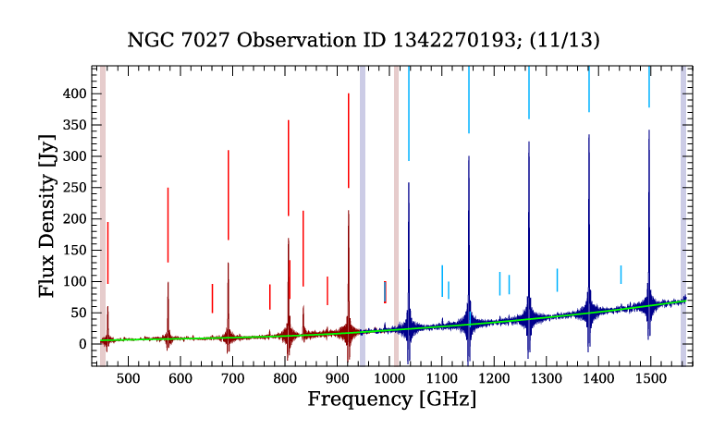

In [14]:
plt.figure(dpi=150)
plt.imshow(sp_prod['postcard'])
plt.axis('off')
plt.show()

The 'spectrum' field in `result` contains the HPDP spectrum for this observation. The data is again stored as an HDUList and it contains detector specific tables. It is worth noting that if FF products do not use HPDP or BGS spectra, the 'spectrum' variable may be either 'HR_point_pnt' or 'HR_point_ext' for point-source calibrated or extended-source calibrated SPG spectra, respectively.

In [15]:
hsa_prod = result['spectrum']

print('Type :', type(hsa_prod), '\n')
hsa_prod.info(); print()

spectrum_table = Table.read(hsa_prod, hdu='SLWC3')

spectrum_table['wave'].info.format = "0.2f"
spectrum_table['flux'].info.format = "0.2f"
spectrum_table['error'].info.format = "0.2f"

print(spectrum_table)#.show_in_notebook()

Type : <class 'astropy.io.fits.hdu.hdulist.HDUList'> 

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     469   ()      
  1  0000          1 ImageHDU        50   ()      
  2  SLWC3         1 BinTableHDU    108   1905R x 5C   [1D, 1D, 1D, 1J, 1J]   
  3  SSWD4         1 BinTableHDU    108   2082R x 5C   [1D, 1D, 1D, 1J, 1J]   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     44   101R x 1C   [351A]   
  6  HistoryTasks    1 BinTableHDU     46   64R x 4C   [1K, 26A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   256R x 10C   [1K, 20A, 7A, 160A, 1L, 1K, 1L, 74A, 11A, 55A]   

  wave   flux error mask numScans
  GHz     Jy    Jy   1      1    
------- ----- ----- ---- --------
 446.99  4.08  3.44    0        8
 447.29  2.90  2.99    0        8
 447.59  3.43  2.13    0        8
 447.89  4.24  1.38    0        8
 448.19  4.79  0.86    0        8
 448.49  4.7

A convenience function called `parse_sparse` exists to parse the `result` variable of sparse observations into something more convenient.

In [16]:
sparse_prod = spio.parse_sparse(sp_prod['catalogue'], 
                                sp_prod['continuum'], 
                                spec_hdu=hsa_prod)
spio._keys_summary(sparse_prod)


___ Summary ___
header:
SLWC3:
--lines
----freq
----snr
--con_par
--wave
--flux
SSWD4:
--lines
----freq
----snr
--con_par
--wave
--flux
_____ End _____



Now each detector contains its own dictionary with fields for detected lines, fitted continuum parameters, spectral frequency axis ('wave'), and spectral flux. Note there is a `detectors` variable in `parse_sparse` which allows you to select a subset of detectors. The default value returns all detectors in the FF features catalogue, and the subset should only included detectors in the default list.

## Off-Axis Sparse Products

The sparse catalogue focuses on the central SLWC3 and SSWD4 detectors from the SPIRE detector arrays. However, a complementary catalogue exists for off-axis detectors. These products can be accessed using the argument `off_axis=True` in the `get_observation` function. The off-axis catalogue is generated by processing exclusively extended calibration spectra to give access to the full detector array including vignetted detectors.

In [17]:
spio.set_verbose(False) # Trun off print statements
offax_obsid = sparse_obsid # 1342191234 obsid currently missing in archive
result = spio.get_observation(offax_obsid, useFF=True, useHsa=True, 
                              cal='ext', spec_type='spg', off_axis=True,
                              save_dir=save_dir, save=True)

The off-axis products have the same structure as the sparse products, but include an additional table containing the radial velocity estimates for each detector. Velocity estimates are included in the meta data of FF sparse products.

In [18]:
offax_prod = result['ff']['sparse_offAx']

offax_prod_cat = offax_prod['catalogue']
print('Type :', type(offax_prod_cat), '\n')
offax_prod_cat.info(); print()

offax_velocity_table = Table.read(offax_prod_cat, hdu='velocity')

offax_velocity_table['velocity'].info.format = "0.2f"
offax_velocity_table['velocityError'].info.format = "0.2f"

print(offax_velocity_table)#.show_in_notebook()

Type : <class 'astropy.io.fits.hdu.hdulist.HDUList'> 

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  DATA          1 BinTableHDU     44   28R x 6C   [1D, 1D, 1D, 5A, 1D, 1J]   
  2  VELOCITY      1 BinTableHDU     19   52R x 4C   [5A, 1D, 1D, 10A]   

detector velocity velocityError velFlag
          km / s      km / s           
-------- -------- ------------- -------
   SLWA1       --            --      --
   SLWA2       --            --      --
   SLWA3       --            --      --
   SLWB1       --            --      --
   SLWB2    47.56         47.10    3,M3
   SLWB3       --            --      --
   SLWB4       --            --      --
   SLWC1       --            --      --
   SLWC2     8.24         39.47    2,M2
   SLWC4   -85.69         62.49    2,M2
     ...      ...           ...     ...
   SSWE5       --            --      --
   SSWE6       --            --      --
   S

The off-axis postcards are also different.

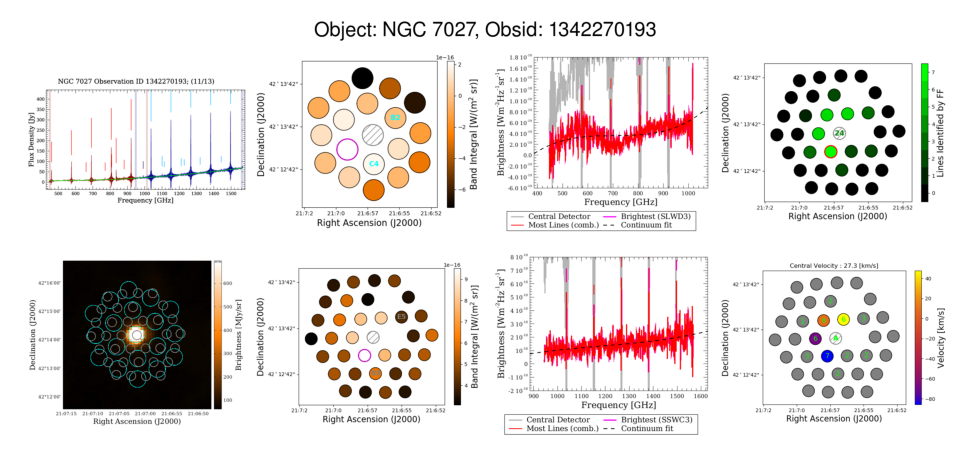

In [19]:
plt.figure(dpi=200)
plt.imshow(offax_prod['postcard'])
plt.axis('off')
plt.show()

## Mapping Products

FF mapping products are generated by processing the spectrum in each pixel of an observation's HSA convolved spectral cube. Spectral cubes exist for both the SLW and SSW band but the results for both cubes are combined into the same FF product. One can access FF and HSA products using the `get_observation` function as before.

Note that mapping products are large and this download may take long time to finish.

In [20]:
map_obsid = 1342192173
result = spio.get_observation(map_obsid, useFF=True, useHsa=True,
                              save_dir=save_dir, save=True)

spio._keys_summary(result)


___ Summary ___
ff:
--mapping
----postcard
----catalogue
----continuum
HR_SSW_cube_convol:
HR_SLW_cube_convol:
_____ End _____



The features catalogue is again an HDUList containing multiple tables. The `data` table contains the detected features with associated parameters. For mapping products, we project the SLW lines into an SSW equivalent grid in order to obtain line lists for the full SPIRE band before attempting to estimate radial velocities. The extra tables give radial `velocity` estimates (and associated parameters) for this SSW equivalent grid, and the number of lines (`nLines`) in each pixel of the combined grid. Since the sky coverage of the SLW and SSW cubes is not identical, the `array` table indicates which bands were used when populating the combined grid.

In [21]:
map_prod = result['ff']['mapping']

map_prod_cat = map_prod['catalogue']
print('Type :', type(map_prod_cat), '\n')
map_prod_cat.info()

Type : <class 'astropy.io.fits.hdu.hdulist.HDUList'> 

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      65   ()      
  1  data          1 BinTableHDU    148   6500R x 13C   [1D, 1D, 1D, 3A, 1K, 1K, 1D, 1D, 1D, 1D, 1D, 3A, 1J]   
  2  velocity      1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  3  velocityError    1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  4  vFlags        1 BinTableHDU    153   27R x 25C   [6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A, 6A]   
  5  nLines        1 BinTableHDU    128   27R x 25C   [1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1D]   
  6  arrays        1 BinTableHDU    153   27R x 25C  

The mapping features catalogue table has additional columns to identify the pixel (`column`, `row`) and coordinate (`ra`, `dec`) the feature was found in, and its associated radial `velocity` estimate.

In [22]:
map_cat_table = Table.read(map_prod_cat, hdu='data')
map_cat_table.info()

<Table length=6500>
     name       dtype   unit 
-------------- ------- ------
     frequency float64    GHz
frequencyError float64    GHz
           SNR float64       
         array    str3       
           row   int64       
        column   int64       
            ra float64       
           dec float64       
   featureFlag float64       
      velocity float64 km / s
 velocityError float64 km / s
         vFlag    str3       
       nccFlag   int32       


The continuum table is modified in a similar way.

In [23]:
map_prod_cont = map_prod['continuum']
map_cont_table = Table.read(map_prod_cont, hdu=1)
map_cont_table.info()

<Table length=747>
 name   dtype 
------ -------
 obsid   str11
 array    str3
   row   int32
column   int32
    ra float64
   dec float64
    p0 float64
 p0err float64
    p1 float64
 p1err float64
    p2 float64
 p2err float64
    p3 float64
 p3err float64


The mapping product postcard is shown below.

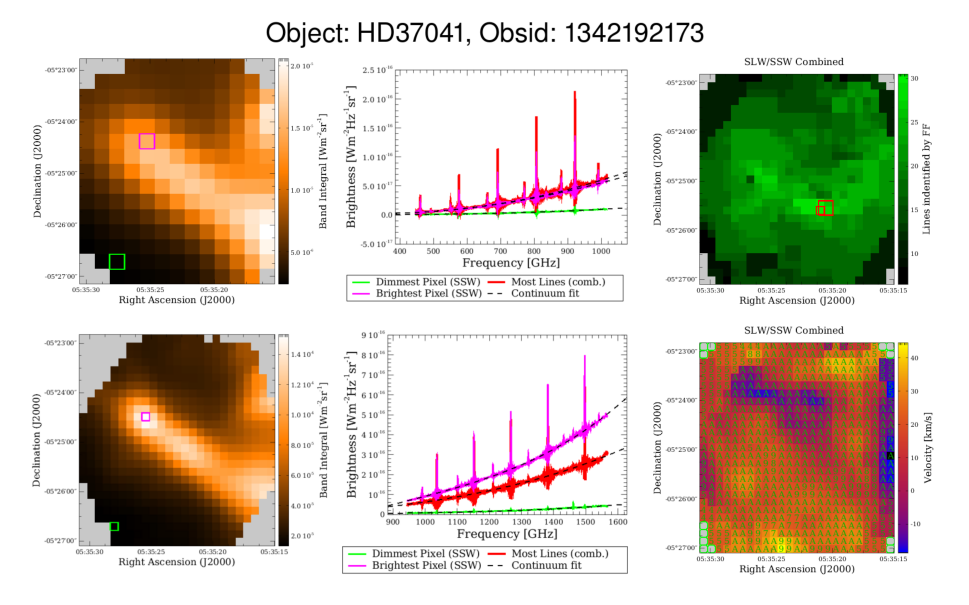

In [24]:
plt.figure(dpi=200)
plt.imshow(map_prod['postcard'])
plt.axis('off')
plt.show()

Finally, we consider one of the spectral cubes in the `result` variable.

In [25]:
cube_slw = result['HR_SLW_cube_convol']
cube_ssw = result['HR_SSW_cube_convol']
print('Type :', type(cube_slw), '\n')
cube_slw.info()

Type : <class 'astropy.io.fits.hdu.hdulist.HDUList'> 

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     330   ()      
  1  image         1 ImageHDU        63   (13, 15, 1905)   float64   
  2  error         1 ImageHDU        63   (13, 15, 1905)   float64   
  3  coverage      1 ImageHDU        63   (13, 15, 1905)   float64   
  4  flag          1 ImageHDU        26   (13, 15, 1905)   int16   


Spectra are stored in the `image` table. It is worth noting that the image is indexed using image[freq][row][col]. A convenience function in the `spireff` package exists to generate the frequency axis for spectral cubes.

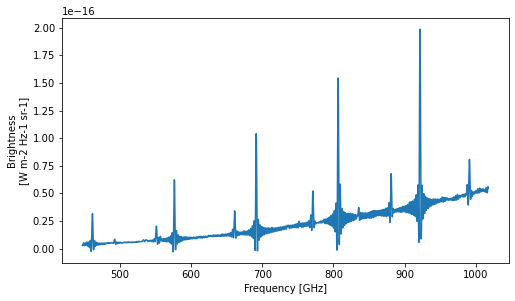

In [26]:
header = cube_slw['image'].header
slw_spec = cube_slw['image'].data

row, col = 6,5
flux = slw_spec[:, row, col]
freq = spio.gen_frequency(cube_slw)

plt.figure(figsize=(8,4.5))
plt.plot(freq, flux)
plt.xlabel('Frequency [GHz]')
plt.ylabel(f'Brightness\n[{header["BUNIT"]}]')
plt.show()

### Parse Mapping

The `spireff` package also has a function for parsing mapping products into a more convenient dictionary.

#### Search by Pixels

By default the `parse_mapping` function will return outputs for all pixels in both bands of the spectral cubes. If the `pixels` argument is provided, it will only return products associated with that pixel.

In [27]:
# for multiple pixels
# pixels = {'SLW': [[cols], [rows]]: SSW: [[cols], [rows]]}

pixels = {'SLW': [col, row]}
cube_hdu = {'SLW': cube_slw, 'SSW': cube_ssw}
map_prod = spio.parse_mapping(map_prod_cat, map_prod_cont, 
                              pixels=pixels, cube_hdu=cube_hdu)
spio._keys_summary(map_prod)


___ Summary ___
header:
SLW[5,6]:
--lines
----freq
----snr
--con_par
--wave
--flux
_____ End _____



With the above implementation, a dictionary is produced for each pixel which contains the main FF products and associated spectrum (if the optional `cube_hdu` argument is defined). Note the notation uses "ary[col][row]", indicating right ascension then declination, to be consistent with the astropy WCS conventions. In some cases, a cascading key structure may be more desirable, which is obtained by setting `flatten=False`. Note the cascading key structure is not supported by the plotting functions in the `spireff.figtools` module.

In [28]:
map_prod = spio.parse_mapping(map_prod_cat, map_prod_cont, 
                              pixels=pixels, cube_hdu=cube_hdu,
                              flatten=False)
spio._keys_summary(map_prod)


___ Summary ___
header:
SLW:
--5
----6
------lines
--------freq
--------snr
------con_par
------wave
------flux
_____ End _____



If `nearest=True`, the output will contain the nearest pixel in the complementary spectral cube.

In [29]:
map_prod = spio.parse_mapping(map_prod_cat, map_prod_cont, 
                              pixels=pixels, cube_hdu=cube_hdu,
                              nearest=True)
spio._keys_summary(map_prod)


___ Summary ___
header:
SLW[5,6]:
--lines
----freq
----snr
--con_par
--wave
--flux
SSW[10,11]:
--lines
----freq
----snr
--con_par
--wave
--flux
_____ End _____



#### Search by Coordinates

It is also possible to search for pixels by coordinates (assumed to use the ICRS frame in degrees) using the `coord` argument. The `radius` argument must be an astropy Quanity and defines a circular region about the coordinates to search for pixels who's centers lie within this region.

In [30]:
# for multiple coords
# coord = [[ras], [decs]]

ra, dec = 83.841, -5.411
coord = [ra, dec]

map_prod = spio.parse_mapping(map_prod_cat, map_prod_cont, 
            cube_hdu=cube_hdu, coords=coord, radius=10*u.arcsec)
spio._keys_summary(map_prod)


___ Summary ___
header:
SLW[7,8]:
--lines
----freq
----snr
--con_par
--wave
--flux
SSW[13,15]:
--lines
----freq
----snr
--con_par
--wave
--flux
SSW[14,14]:
--lines
----freq
----snr
--con_par
--wave
--flux
SSW[14,15]:
--lines
----freq
----snr
--con_par
--wave
--flux
_____ End _____



To recover a pixels list from the outputs of `parse_mapping`, one can use the `_pixels_in_mapping_products` function.

In [31]:
pixels_ = spio._pixels_in_mapping_products(map_prod)
print(pixels_)

{'SLW': [[7], [8]], 'SSW': [[13, 14, 14], [15, 14, 15]]}


### Velocity Maps

The FF mapping products contain a table with radial velocity estimates for each pixel of the SSW equivalent gird. We can access this table and create a 2d-numpy array from the data in the following way.

In [32]:
velocity_table = map_prod_cat['velocity'].data
velocity_map = np.array([list(row) for row in velocity_table])

To display these maps on sky, we require an astropy WCS object. The `spireff` module can generate these objects from the FF continuum products using the `_make_wcs` function.

In [33]:
wcs = spio._make_wcs(map_prod_cont)
print(wcs)

{'SLW': WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.864949408156  -5.4500830145351  
CRPIX : 3.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0048611327426796  0.0048611327426796  
NAXIS : 13  15, 'SSW': WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 83.866623652742  -5.4503607359169  
CRPIX : 5.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.0026388940782857  0.0026388940782857  
NAXIS : 25  27}


Since the velocity maps use the SSW cube griding, we only use the SSW WCS object.

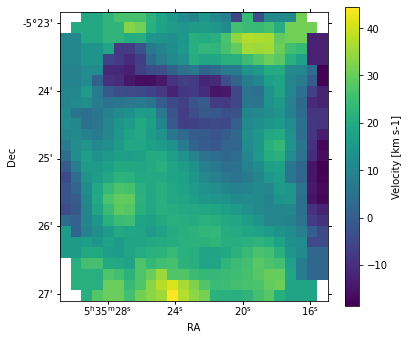

In [34]:
v_unit = map_prod_cat['data'].header['TUNIT11']

fig = plt.figure(figsize=(6, 5.5))
ax = fig.add_subplot(111, projection=wcs['SSW'])
img = ax.imshow(velocity_map,  origin='lower')
fig.colorbar(img, label=f"Velocity [{v_unit}]")
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

# Visualization

The `spireff` module contains a few functions to help quickly visualize FF and HSA products.

## Sparse Postcards

The `sparse_postcard` function takes FF and HSA products as inputs and produces a plot that follows the style of the standard FF sparse postcards. Although not strictly required, it is recommended that only one set of SLW and SSW products be passed to the function at a time.

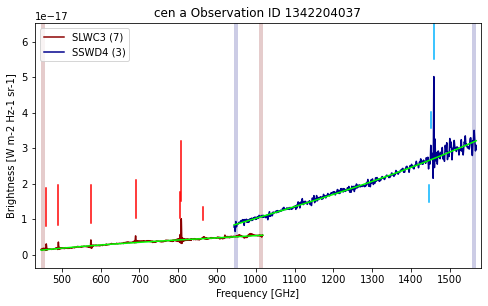

In [35]:
obsid = 1342204037
result = spio.get_observation(obsid, useFF=True, useHsa=True,
                              save_dir=save_dir, save=True)
cat = result['ff']['sparse_ext']['catalogue']
cont = result['ff']['sparse_ext']['continuum']
spec_hdu = result['HR_spectrum_ext']
spec_prod = spio.parse_sparse(cat, cont, spec_hdu=spec_hdu)

fig_kwargs = {'figsize': (8,4.5)}
fig, ax = tools.sparse_postcard(spec_prod, fig_kwargs=fig_kwargs)

## Photometer Images

The discontinuity between the SLW and SSW continua is due to the semi-extended nature of the source. We can get a broader view of the source by looking at its SPIRE photometer image. Note that the photometer bands are centered at 250$\mu$m (PSW), 350$\mu$m (PMW), and 500$\mu$m (PLW) while the spectrometer covers a range from 191–671$\mu$m.

We can locate a complementary photometer obsid in the HSA product meta data. The keyword is typically "POBS_XXX" where "XXX" is a three digit number starting at 000 indexing a list of photometer obsids. 

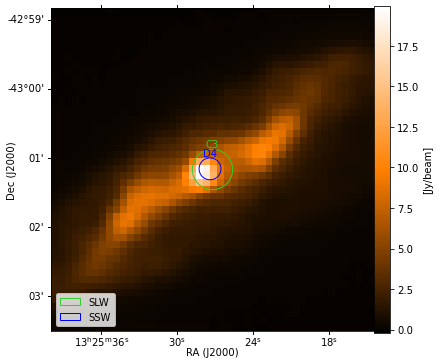

In [36]:
phot_obsid = spec_hdu[0].header['POBS_000']
result = spio.get_observation(phot_obsid, useHsa=True, 
        photo_band='PSW', save_dir=save_dir, save=True)
phot_hdu = result['psrcPSW']

detectors = ['SLWC3', 'SSWD4'] # try : None, ['SLWC3', 'SSWD4']
annotate = True # try : True, False
fig_kwargs = {'figsize': (6.8, 6)}
foot_color = {'SLW': 'limegreen', 'SSW': 'blue'}
fig, ax, img, wcs = tools.sky_image(phot_hdu, foot_data=spec_hdu, 
                                    annotate=annotate, detectors=detectors,
                                    foot_color=foot_color, fig_kwargs=fig_kwargs)
_ = ax.legend(loc=3)

Virtually all elements of the plot can be controlled by additional kwargs in the `sky_image` function (see doc string), or by manipulating the function output variables.

## Additional Example

As an additional example of how to leverage the `spireff` package, we generate a figure with a photometer image and sparse postcard as subplots for a mapping observation. In doing so we only need specify the mapping obsid and the pixel(s) from a spectral cube we are interested in.

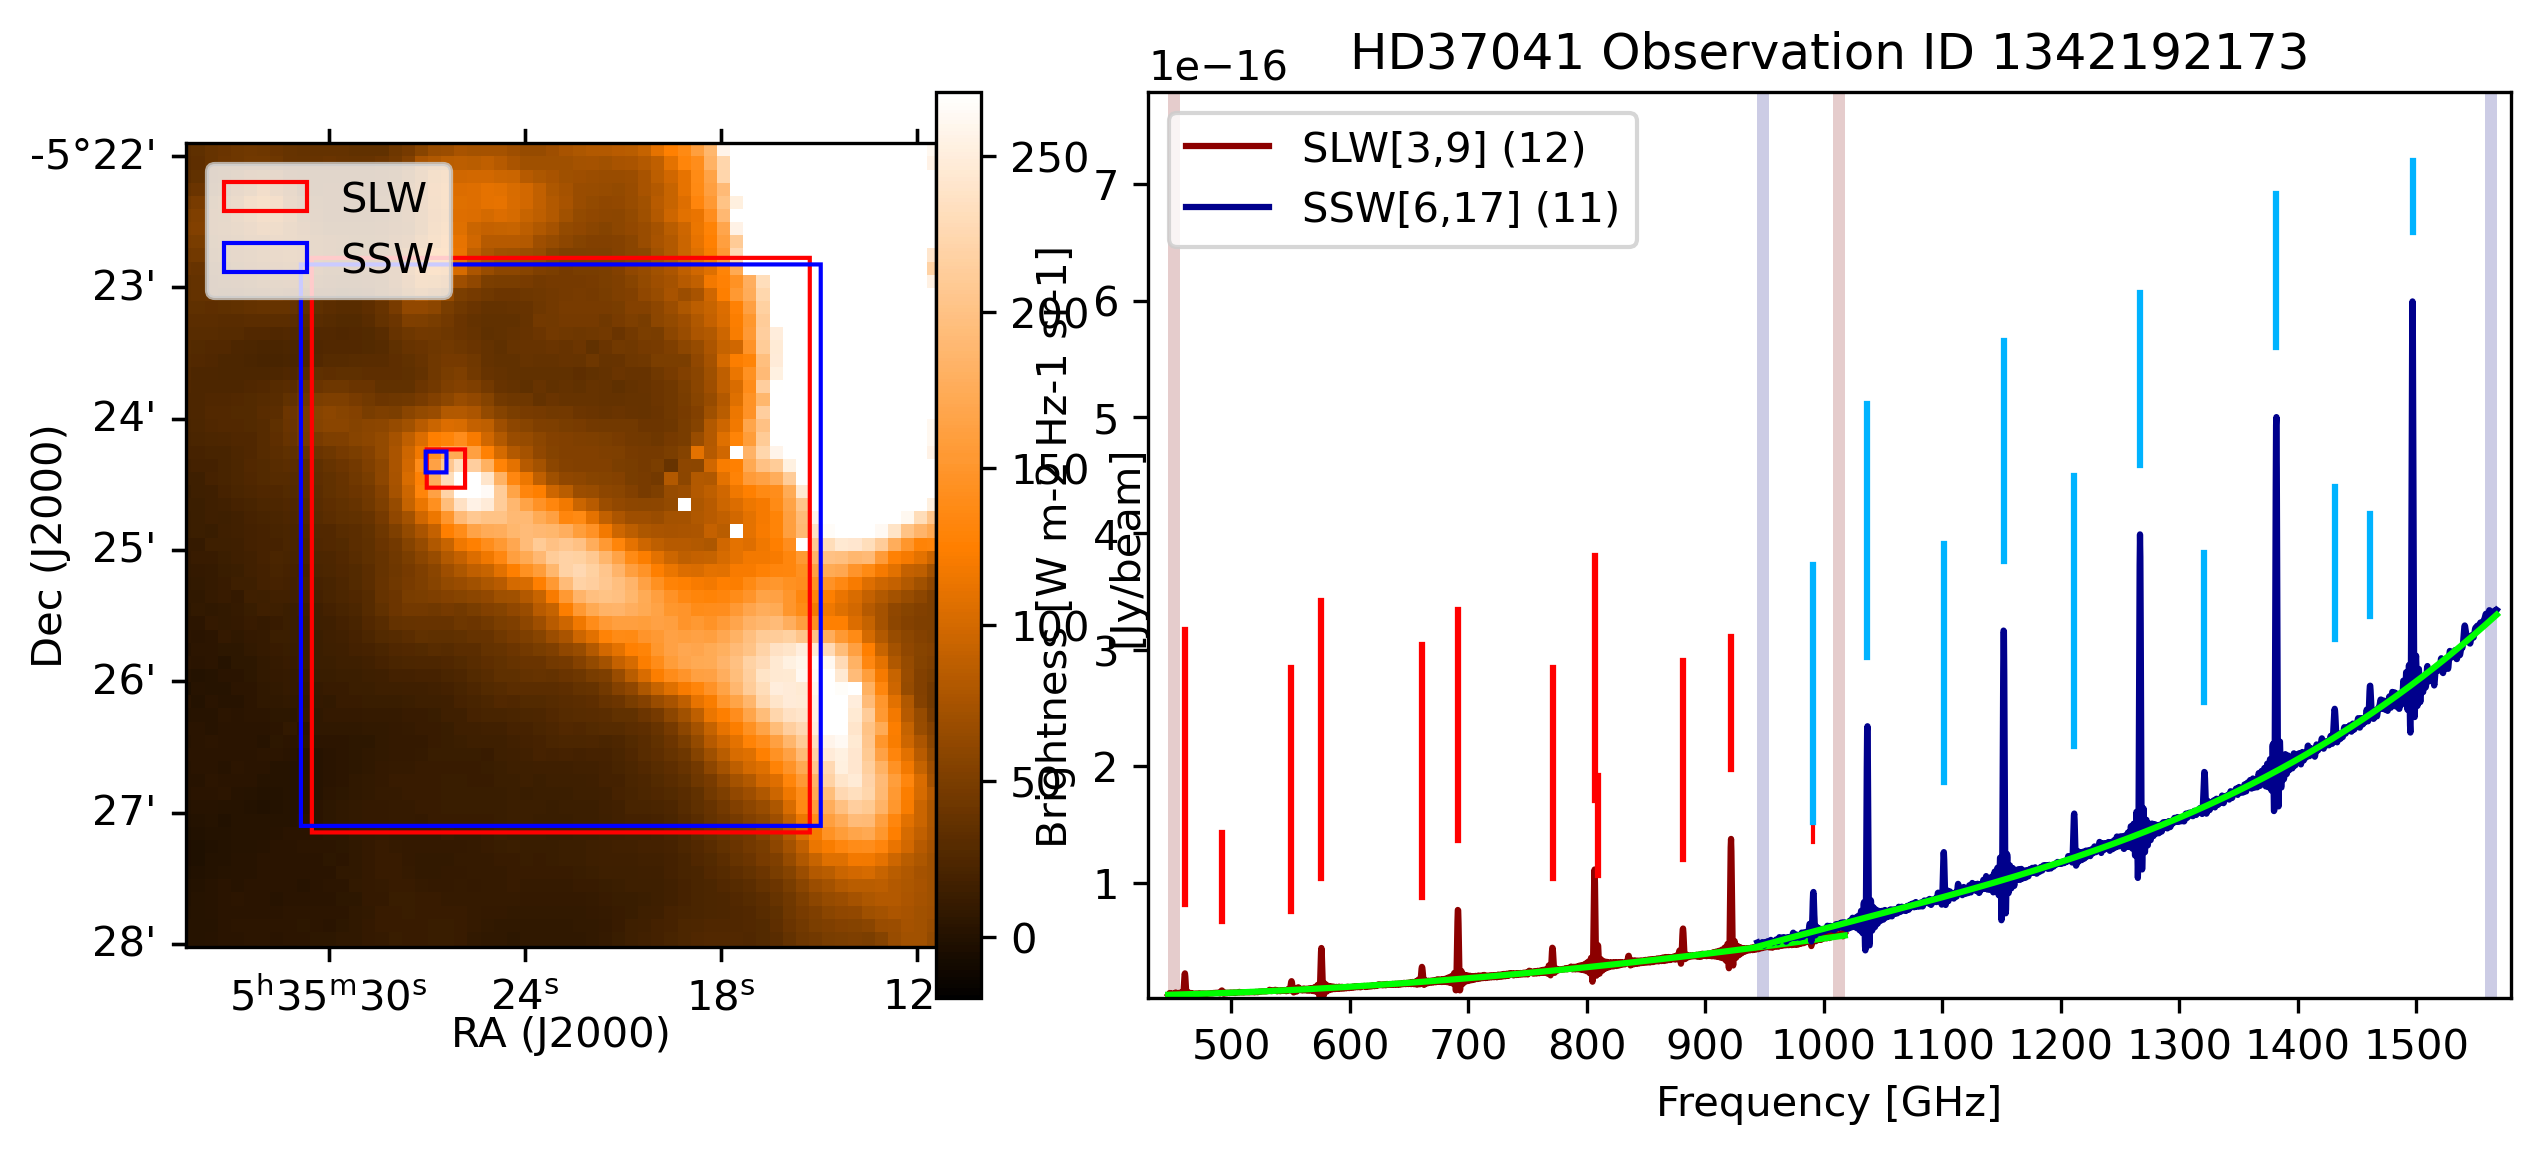

In [37]:
map_obsid = 1342192173
pixels = {'SLW': [3, 9]}

# Retrieve FF and HSA products
result = spio.get_observation(map_obsid, useFF=True, useHsa=True,
                              save_dir=save_dir, save=True)
map_prod_cat = result['ff']['mapping']['catalogue']
map_prod_cont = result['ff']['mapping']['continuum']
cube_slw = result['HR_SLW_cube_convol']
cube_ssw = result['HR_SSW_cube_convol']
cube_hdu = {'SLW': cube_slw, 'SSW': cube_ssw}
phot_obsid = cube_slw[0].header['POBS_000']

# Parse the data
map_prod = spio.parse_mapping(map_prod_cat, map_prod_cont, 
                              pixels=pixels, cube_hdu=cube_hdu,
                              nearest=True)
pixels_ = spio._pixels_in_mapping_products(map_prod)

# Retrieve Photometer Image
result = spio.get_observation(phot_obsid, useHsa=True, 
        photo_band='PSW', save_dir=save_dir, save=True)
phot_hdu = result['psrcPSW']

# Plotting
fig = plt.figure(figsize=(10,4), dpi=300)
gs = fig.add_gridspec(1, 5)
fig, ax = tools.sparse_postcard(map_prod, fig=fig, index=gs[0,2:])
fig, ax, img, wcs = tools.sky_image(phot_hdu, foot_data=[cube_slw, cube_ssw], 
                                    pixels=pixels_, fig=fig, index=gs[0,:2])
_ = ax.legend(loc=2)
plt.tight_layout()

# Integrated Flux

When analyzing a spectrum, one is often interested in the integrated flux of spectral features. Integrated flux of spectral features is not provided in the FF products because obtaining accurate values typically requires careful analysis of the associated spectra. With this consideration, we demonstrate below a simple approach for obtaining rough estimates of the integrated flux for features detected by the FF. 

The proposed procedure involves fitting detected features using a Sinc model, which closely approximates the empirical line shape of the SPIRE FTS, and extracting the integrated flux analytically from the fitted line parameters. This process is similar to the method employed by the the standard spectral line fitting analysis script used by the Herschel Interactive Processing Environment (HIPE). Typically one would include the continuum in the fitted model, but in our case, we will simply use continuum subtracted spectral data where the fitted continuum is provided by the FF. 

The Sinc function is given by

\begin{equation}
f(\nu) = A \frac{\sin(\mathrm{arg})}{\mathrm{arg}} \\
\mathrm{arg} = \frac{\pi(\nu - C)}{W}
\end{equation}

where $A$ and $C$ define the amplitude and centroid of the spectral feature, respectively. The width of the spectral feature, $W$, corresponds the the spectral resolution of the FTS ($\approx$ 1.18 GHz for SPIRE). With these parameters, the integrated line flux of an unresolved spectral feature is

\begin{equation}
\int_{-\infty}^{\infty} f(\nu) \; d\nu = AW
\end{equation}

This analytic expression is used to calculate integrated line flux in the code below.

Note: The Sinc function expresses decaying side-lobes which produce non-local effects in the spectrum. For this reasons, fitting a single spectral feature is not recommended. The best most physically real results are obtained when simultaneously fitting all detected features in the spectrum (ie, either the entire SLW or SSW band). We will perform our analysis on the already loaded mapping products from above.

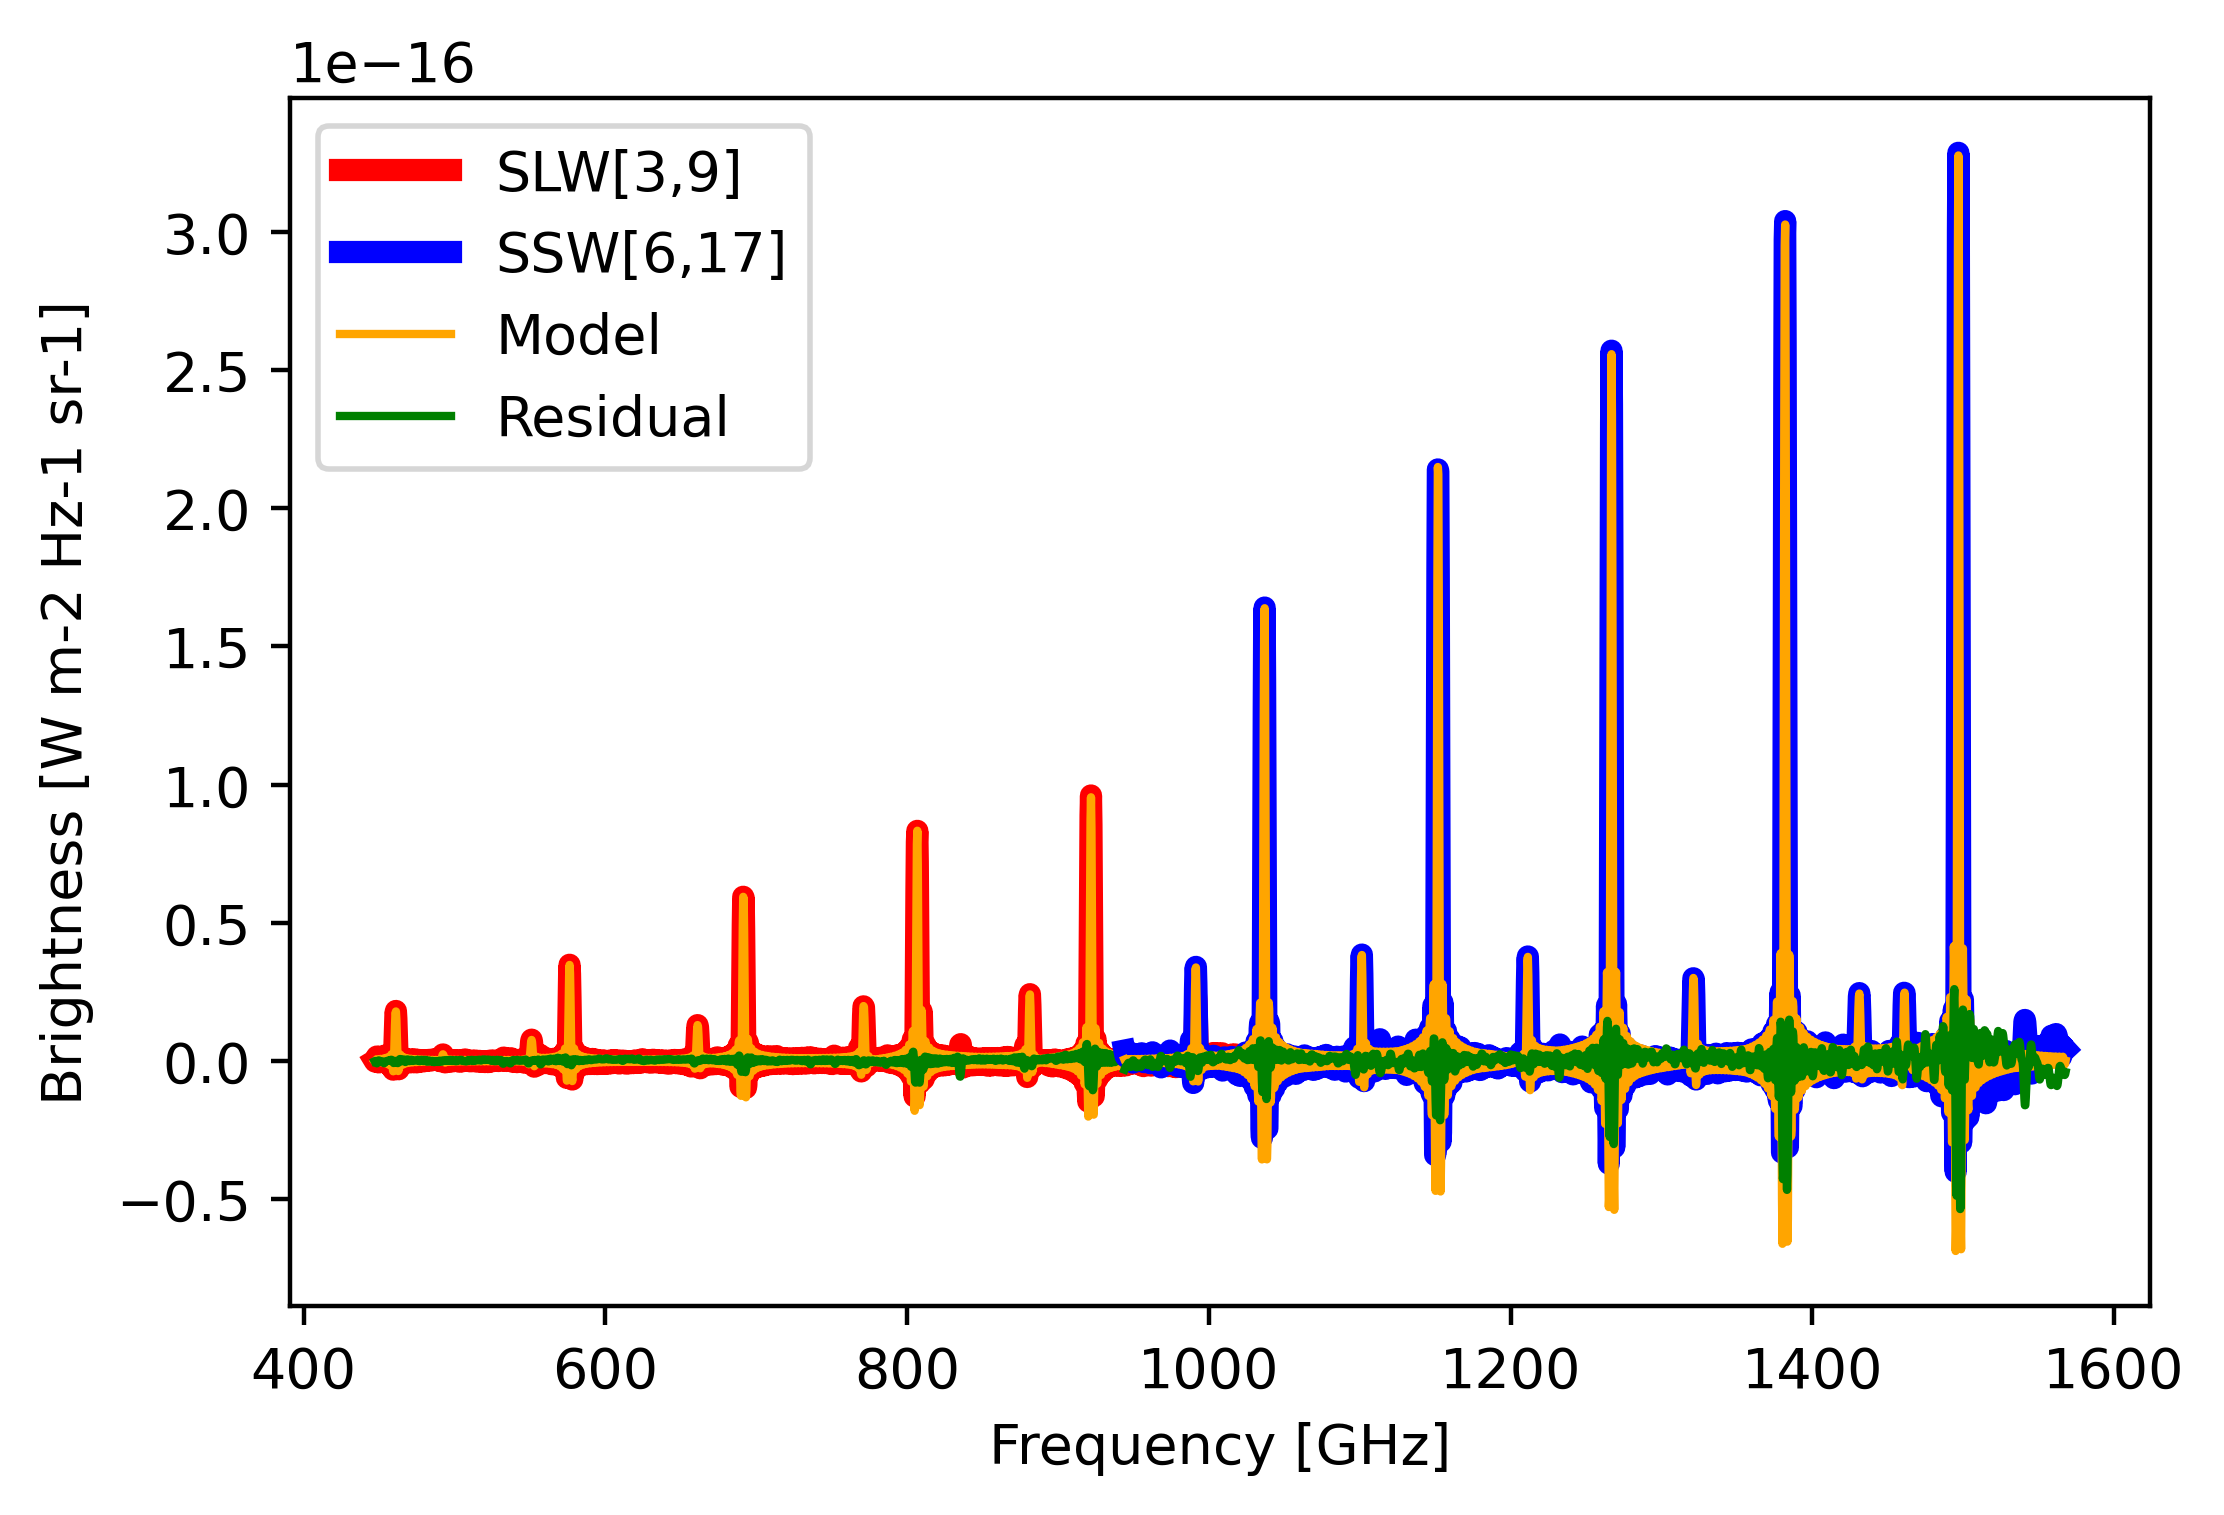

In [38]:
model_prod = tools.model_spectrum(map_prod, vary_width=False)
colors = {'SLW': 'red', 'SSW': 'blue'}
flux_unit = cube_slw[1].header['BUNIT']
freq_unit = cube_slw[1].header['CUNIT3']

fig = plt.figure(figsize=(6,4), dpi=400)
for key, val in model_prod.items():
    if key == 'header':
        continue
    ary = 'SLW' if 'SLW' in key else 'SSW'
    flux_sub = val['flux'] - val['cont']
    plt.plot(val['wave'], flux_sub, color=colors[ary], linewidth=4.0, label=key)
    (axm,) = plt.plot(val['wave'], val['model'].best_fit, color='orange')
    (axr,) = plt.plot(val['wave'], val['model'].residual, color='green')
    if ary == 'SSW':
        axm.set_label('Model')
        axr.set_label('Residual')
plt.xlabel(f'Frequency [{freq_unit}]')
plt.ylabel(f'Brightness [{flux_unit}]')
plt.legend(loc=0)
plt.show()

In the above example we have assumed the spectral features are not resolved. When analyzing partially or fully resolved spectral features, best results are obtained when modeling the spectral features as Sinc convolved Gaussians. However, for a quick estimate of integrated flux, one can simply set the `vary_width` keyword variable in the `model_spectrum` function to `True`. The large majority of spectral features in the SPIRE FTS dataset are unresolved and the above script should be sufficient in most cases. 

Below we calculate the integrated flux of spectral features using the fitted model parameters.

In [39]:
for key, val in model_prod.items():
    if key == 'header':
        continue
    fit_pars = val['model'].params
    print(f'\n{key:-^65}')
    print('Frequency [GHz]     Flux [W m-2 sr-1]     Flux Error [W m-2 sr-1]')
    print('-'*65)
    for comp in val['model'].components:
        pref = comp.prefix
        amp = fit_pars[f'{pref}amp']
        freq = fit_pars[f'{pref}cent']
        width = fit_pars[f'{pref}width']
        flux = amp.value*width.value*1e9
        fluxErr = flux*np.sqrt((amp.stderr/amp.value)**2 + (width.stderr/width.value)**2)
        print(f"{freq.value:10.2f} {flux:21.3e} {fluxErr:25.3e}")


----------------------------SLW[3,9]-----------------------------
Frequency [GHz]     Flux [W m-2 sr-1]     Flux Error [W m-2 sr-1]
-----------------------------------------------------------------
    460.99             2.132e-08                 7.027e-10
    550.95             9.327e-09                 7.014e-10
    576.23             4.138e-08                 7.014e-10
    661.12             1.618e-08                 7.013e-10
    691.45             7.218e-08                 7.013e-10
    771.24             2.434e-08                 7.013e-10
    881.33             2.799e-08                 7.013e-10
    921.84             1.129e-07                 7.014e-10
    991.42             2.811e-08                 7.019e-10
    806.68             9.864e-08                 7.043e-10
    809.31             1.020e-08                 7.043e-10
    492.20             2.450e-09                 7.017e-10

----------------------------SSW[6,17]----------------------------
Frequency [GHz]     Flux [

## Unit Conversion for Integrated Flux

It is often convenient to express integrated flux in alternative units. Here we summarize how to convert from standard SPIRE FTS integrated line flux units to a few other commonly encountered units. For a more comprehensive overview, please see "SPIRE FTS: converting integrated line fluxes to alternative units".

### Point Source Calibration

Since point source calibrated spectra in SPIRE are presented in units of Janskys, employing the analytical equation for integrated line flux returns units of [Jy GHz]. To obtain integrated line flux in SI units use

\begin{equation}
F_{\mathrm{line}} = AW \times 10^{-17} \qquad [\mathrm{W \; m^{-2}}]
\end{equation}

where $A$ is in units of Jy and $W$ is in units of GHz. All the following unit conversions for point source calibrated spectra will be done with respect to $F_{\mathrm{line}}$. 

#### $[\mathrm{W \; m^{-2}}] \rightarrow [\mathrm{erg \; cm^{-2} \; s^{-1}}]$ 

This conversion requires only a multiplicative factor,

\begin{equation}
F' = F_{\mathrm{line}} \times 10^3 \qquad [\mathrm{erg \; cm^{-2} \; s^{-1}}]
\end{equation}

#### $[\mathrm{W \; m^{-2}}] \rightarrow [\mathrm{Jy \; km \; s^{-1}}]$

This conversion requires a multiplicative factor and the rest frame emission frequency, $\nu_0$, of the line in question using units of GHz.

\begin{equation}
F' = \frac{F_{\mathrm{line}} \; (9.418 \times 10^{19})}{\nu_0} \qquad [\mathrm{Jy \; km \; s^{-1}}]
\end{equation}

Alternatively, one can use the rest frame emission wavelength, $\lambda_0$, of the line in question using units of $\mu\mathrm{m}$.

\begin{equation}
F' = F_{\mathrm{line}} \; \lambda_0 \; (\pi \times 10^{7}) \qquad [\mathrm{Jy \; km \; s^{-1}}]
\end{equation}

#### $[\mathrm{W \; m^{-2}}] \rightarrow [\mathrm{K \; km \; s^{-1}}]$

The temperature unit Kelvins in the desired units is in reference to the so called "brightness temperature" and is a useful quantity for FIR/submm and radio astronomy. This conversion is somewhat more complicated in that it requires knowledge of the frequency dependent SPIRE FTS beam width. We use $\theta_b(\nu)$, in units of arcseconds, to denote the frequency dependent Full Width at Half Maximum (FWHM) of the beam. For SPIRE, this empirically derived function can be obtained from the following [link](http://archives.esac.esa.int/hsa/legacy/ADP/PSF/SPIRE/SPIRE-S/), but can also be accessed using the `frequency_beam` function in the `spireff.io` library. Both the SPIRE SLW and SSW detector arrays have their own functions. The conversion is then

\begin{equation}
F' = \frac{F_{\mathrm{line}} \; (1.149 \times 10^{29})}{\theta_b^2(\nu) \; \nu_0^3} \qquad [\mathrm{K \; km \; s^{-1}}]
\end{equation}

Note that $\nu_0$ is again the rest frame emission frequency of the line in question in units of GHz, and $\theta_b(\nu)$ is the beam FWHM at the detected frequency of the line in question. Since this conversion is nontrivial, we provide a sample conversion below.

In [40]:
freq_det = 482.1 # feature detection frequency [GHz]
freq_0 = 500.0 # rest frame frequency for detected feature [GHz]
amp = 1 # amplitude of detected feature [Jy]
width = 1.18448225 # width of sinc function [GHz]

slw_beam = spio.frequency_beam(save_dir=save_dir, save=True)['SLW']

# beam FWHM at detection frequency
interp = interp1d(slw_beam['frequency'], slw_beam['FWHM'])
theta = interp(freq_det)

# calculated integrated line flux [W m-2]
F_line = amp*width*1e-17
# conversion to [K km s-1]
F_ = F_line*1.149e29/theta**2/freq_0**3

print(f"Integrated line flux:\n F_line = {F_line:.2e} "
      f"[W m-2]\n F_ = {F_:.2f} [K km s-1]")

Integrated line flux:
 F_line = 1.18e-17 [W m-2]
 F_ = 6.81 [K km s-1]


### Extended Source Calibration

Since extended source calibrated spectra in SPIRE are presented in units of [W m-2 Hz-1 sr-1], employing the analytical equation for integrated line flux returns units of [W GHz m-2 Hz-1 sr-1]. To obtain integrated line flux in SI units use

\begin{equation}
F_{\mathrm{line}} = AW \times 10^{9} \qquad [\mathrm{W \; m^{-2} \; sr^{-1}}]
\end{equation}

where $A$ is the amplitude of the feature in units of [W m-2 Hz-1 sr-1], and $W$ is the width of the feature in units of GHz.

#### $[\mathrm{W \; m^{-2} \; sr^{-1}}] \rightarrow [K]$

The desired temperature units of Kelvins is again in relation to the so called "brightness temperature". For extended source calibrated spectra, the conversion requires simply a multiplicative factor and the emission rest frequency, $\nu_0$, of the spectral feature in question in units of GHz. The conversion is given by

\begin{equation}
F' = \frac{F_{\mathrm{line}} (1.04 \times 10^{12})}{\nu_0^2} \qquad [K]
\end{equation}

# Conclusion

The Herschel/SPIRE Spectral Feature Finder is an automated tool which attempts to detect significant spectral features within SPIRE FTS data. This tool and the resulting dataset is designed to help with preliminary analysis and data mining of SPIRE spectral data and is not intended to replaced detailed analysis. In this document we have demonstrated how to retrieve FF products through a Python interface and how to query these products for features meeting specific search criteria. We also outlined simple methods for displaying FF results including plotting FF features and fitted continua over the SPIRE spectra obtained from the HSA, and displaying velocity maps for mapping observations. Finally, we provided sample code for how to extract integrated line flux for detected spectral features and outlined conversion methods for obtaining the integrated flux in other common units.